## Baseline Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from src.data_loading import load_adult_sex
from src.data_loading import load_adult_race
from src.modeling import train_and_predict
from src.metrics import compute_metrics

/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
# 1) Retrieve data
protected = 'sex'
privileged_value   = 1.0
unprivileged_value = 0.0

ad, df = load_adult_sex()
feature_cols = [c for c in df.columns if c not in ('label','sex')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = train_and_predict(
        df, feature_cols, train_idx, test_idx
    )
    m = compute_metrics(test_df, y_test, y_pred, protected, privileged_value, unprivileged_value)
    results.append(m)

# 3) Aggregate results
adult_sex_metrics = pd.DataFrame(results)
adult_sex_metrics_agg = adult_sex_metrics.agg(['mean', 'std'])

In [3]:
adult_sex_metrics_agg

,accuracy,f1_score,SPD,DI,EOD,AOD
mean,0.850310,0.654344,-0.174734,0.306197,-0.096939,-0.086041
std,0.002709,0.005680,0.007062,0.020650,0.024995,0.013352


In [4]:
df

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass=Government,workclass=Private,workclass=Self-Employed,education=<HS,...,relationship=Own-child,relationship=Unmarried,relationship=Wife,race=White,native-country=Canada,native-country=Germany,native-country=Mexico,native-country=Philippines,native-country=United-States,label
0,25.0,7.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,38.0,9.0,1.0,0.0,0.0,50.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,28.0,12.0,1.0,0.0,0.0,40.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,44.0,10.0,1.0,7688.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,18.0,10.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,12.0,0.0,0.0,0.0,38.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
48838,40.0,9.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
48839,58.0,9.0,0.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
48840,22.0,9.0,1.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
# 1) Retrieve data
protected = 'race'
privileged_value   = 1.0
unprivileged_value = 0.0

ad, df = load_adult_race()
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = train_and_predict(
        df, feature_cols, train_idx, test_idx
    )
    m = compute_metrics(test_df, y_test, y_pred, protected, privileged_value, unprivileged_value)
    results.append(m)

# 3) Aggregate results
adult_race_metrics = pd.DataFrame(results)
adult_race_metrics_agg = adult_race_metrics.agg(['mean', 'std'])

In [6]:
adult_race_metrics_agg

,accuracy,f1_score,SPD,DI,EOD,AOD
mean,0.850605,0.656032,-0.084891,0.590458,-0.047565,-0.038272
std,0.002979,0.005996,0.005642,0.025659,0.022491,0.010729


In [7]:
df

,age,education-num,race,capital-gain,capital-loss,hours-per-week,workclass=Government,workclass=Private,workclass=Self-Employed,education=<HS,...,relationship=Own-child,relationship=Unmarried,relationship=Wife,sex=Male,native-country=Canada,native-country=Germany,native-country=Mexico,native-country=Philippines,native-country=United-States,label
0,25.0,7.0,0.0,0.0,0.0,40.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,38.0,9.0,1.0,0.0,0.0,50.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,28.0,12.0,1.0,0.0,0.0,40.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,44.0,10.0,0.0,7688.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,18.0,10.0,1.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,12.0,1.0,0.0,0.0,38.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
48838,40.0,9.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
48839,58.0,9.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
48840,22.0,9.0,1.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


-----------------------------------------------------------------------
### plots and save to csv

In [10]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

from src.metrics import viz_metrics_2x3, compare_viz_metrics_2x3, save_agg_metrics, save_raw_metrics

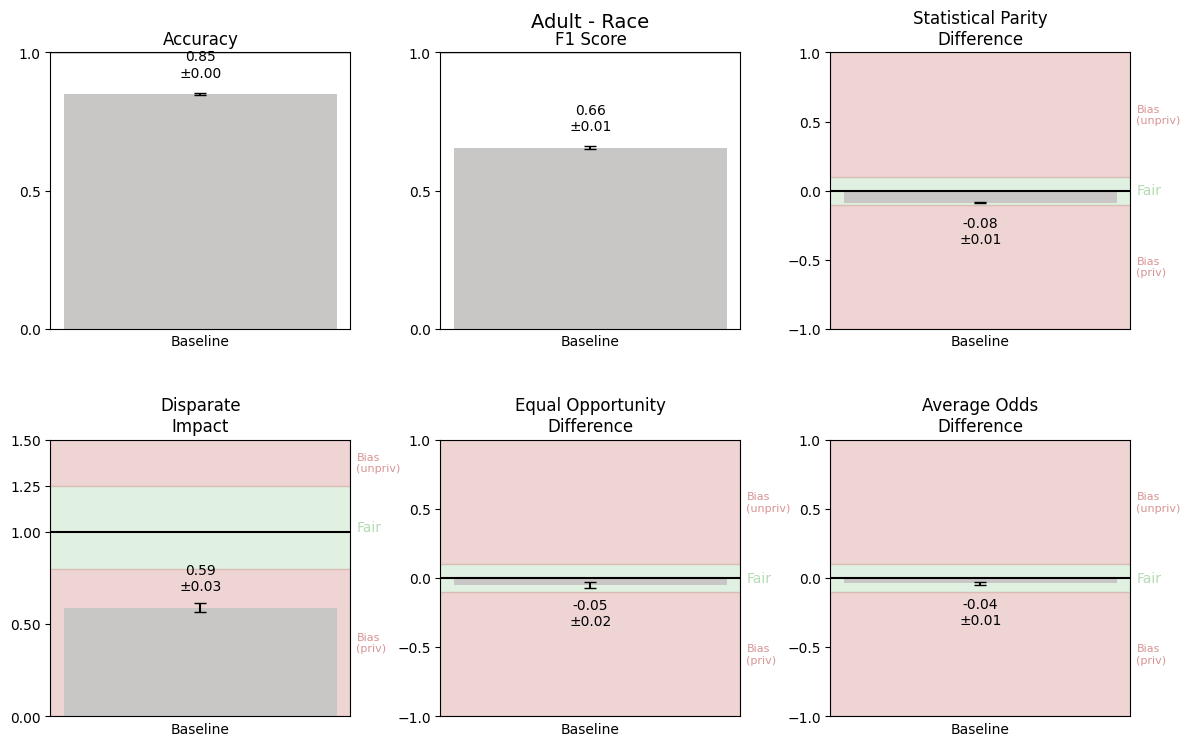

In [11]:
viz_metrics_2x3(adult_race_metrics_agg, title='Adult - Race')

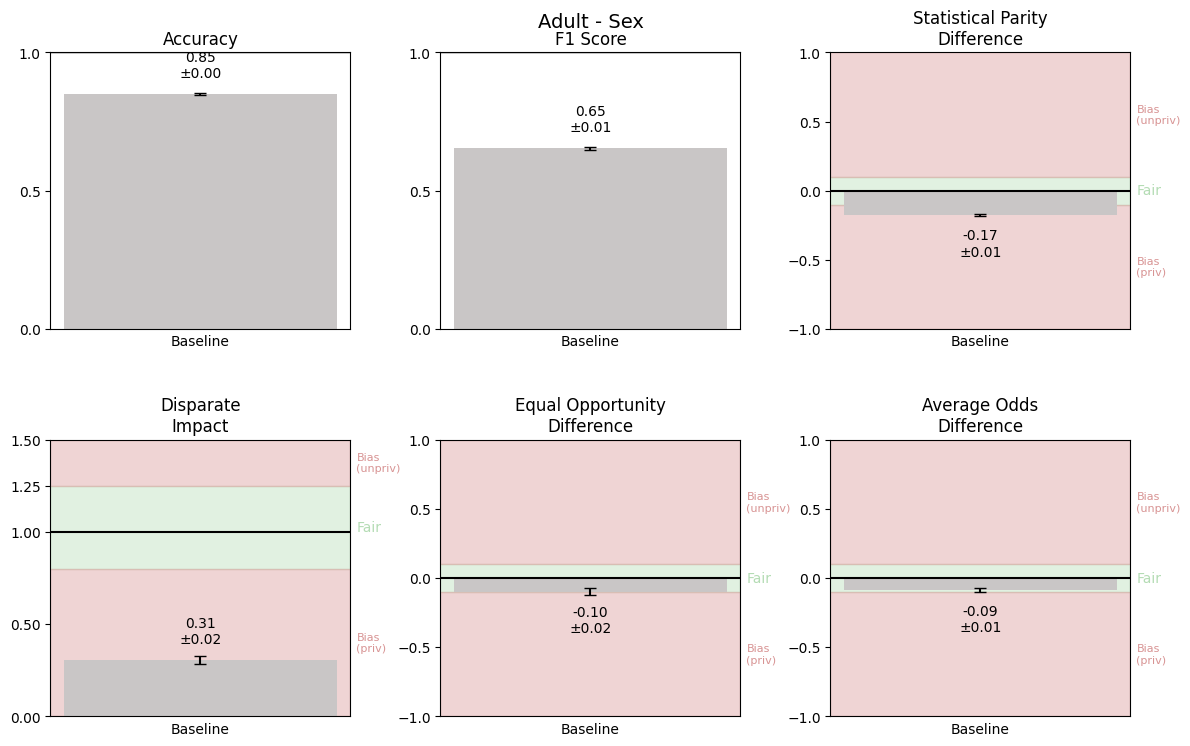

In [12]:
viz_metrics_2x3(adult_sex_metrics_agg, title='Adult - Sex')

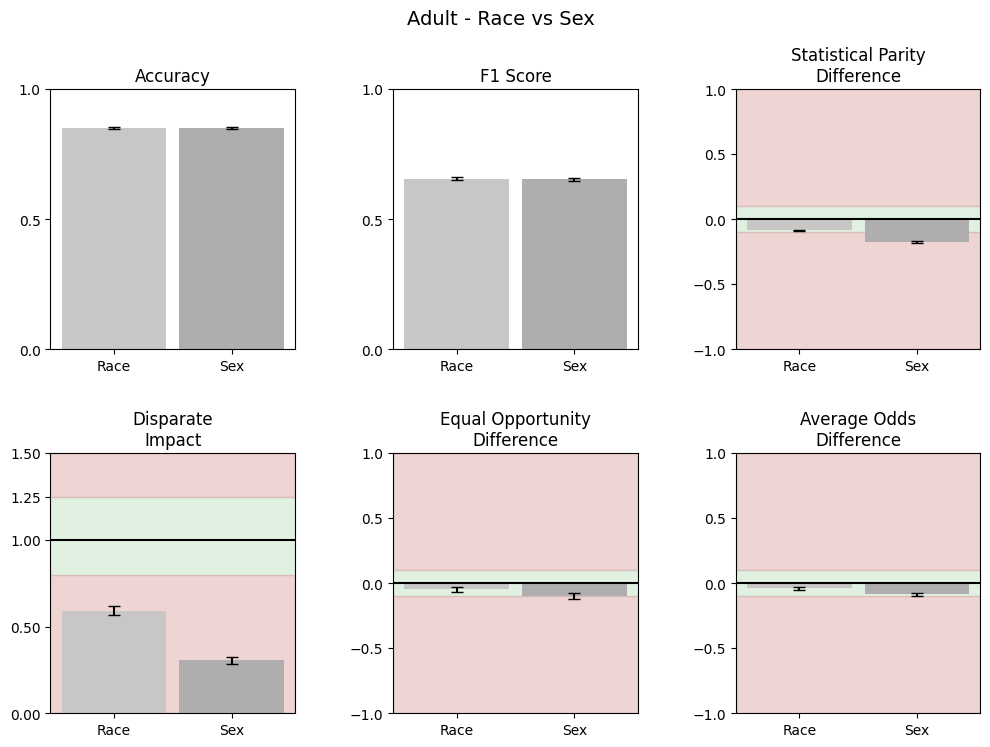

In [13]:
compare_viz_metrics_2x3(adult_race_metrics_agg, adult_sex_metrics_agg, 'Race', 'Sex', 'Adult Baseline - Race vs Sex')

In [14]:
save_agg_metrics('adult', 'baseline', adult_race_metrics_agg, adult_sex_metrics_agg)
save_raw_metrics('adult', 'baseline', adult_race_metrics, adult_sex_metrics)

#### Extract Baseline agg 
-- for easier comparison with the mitigation methods

In [ ]:
adult_race_metrics_agg.to_csv('../../reports/baseline_agg/adult_race_metrics_agg.csv', index=True)
adult_sex_metrics_agg.to_csv('../../reports/baseline_agg/adult_sex_metrics_agg.csv', index=True)